In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import matplotlib.pyplot as plt

Settings

In [3]:
weight_type = 'generalized_advantage_estimate'
environment_name = 'CartPole-v1'
learning_rate = 1e-3
epochs = 100
batch_size = 1000
discount = 0.95
gae_lambda = 0.95

Global variables

In [4]:
environment = gym.make(environment_name)
observation_dimension = environment.observation_space.shape[0]
action_dimension = environment.action_space.n
policy_network = nn.Sequential(
    nn.Linear(observation_dimension, 100), nn.ReLU(inplace=True),
    nn.Linear(100, 100), nn.ReLU(inplace=True),
    nn.Linear(100, 100), nn.ReLU(inplace=True),
    nn.Linear(100, action_dimension)
)
optimizer = Adam(policy_network.parameters(), lr=learning_rate)
value_network = nn.Sequential(
    nn.Linear(observation_dimension, 20), nn.ReLU(inplace=True),
    nn.Linear(20, 20), nn.ReLU(inplace=True),
    nn.Linear(20, 20), nn.ReLU(inplace=True),
    nn.Linear(20, 1)
)
value_optimizer = Adam(value_network.parameters(), lr=learning_rate)


Helper functions

In [5]:
def generalized_advantage_estimate(batch_rewards, batch_done, batch_values):
    advantages = [0]*len(batch_rewards)
    not_done = [1 - d for d in batch_done]  # done is array indicating 'last' frames
    #  not_done array: if value is done future advantage should not influence.
    # the last advantage = last reward + gamma * V_bs * not_done_boolean - last value
    advantages[-1] = batch_rewards[-1] - batch_values[-1]
    for t in reversed(range(len(batch_rewards) - 1)):
        delta = batch_rewards[t] + discount * batch_values[t + 1] * not_done[t] - batch_values[t]
        advantages[t] = delta + discount * gae_lambda * not_done[t] * advantages[t + 1]
    return advantages

def reward_to_go(rewards):
    T = len(rewards)
    reward_to_gos = np.zeros_like(rewards)
    for t in reversed(range(T)):
        reward_to_gos[t] = rewards[t] + (reward_to_gos[t+1] if t+1 < T else 0)
    return reward_to_gos

def policy_forward(observation):
    logits = policy_network(observation)
    return Categorical(logits=logits)

def evaluate_policy(observation):
    return policy_forward(observation).sample().item()

def compute_loss(observation, action, weights):
    log_probability = policy_forward(observation).log_prob(action)
    return -(log_probability * weights).mean()

def value_forward(observation):
    return value_network(observation)

def compute_value_loss(observation, target):
    return ((value_network(observation) - target)**2).mean()

def train_one_epoch():
    batch_weights = []
    batch_observations = []
    batch_actions = []
    batch_rewards = []
    batch_done = []
    epoch_returns = []
    episode_lengths = []
    
    observation = environment.reset()
    done = False
    episode_rewards = []
    while True:
        batch_observations.append(observation.copy())
        action = evaluate_policy(torch.as_tensor(observation, dtype=torch.float32))
        observation, reward, done, info = environment.step(action)
        episode_rewards.append(reward)
        batch_actions.append(action)
        batch_done.append(done)
        batch_rewards.append(reward)
        if done:
            episode_return = sum(episode_rewards)
            episode_length = len(episode_rewards)
            if 'reward_to_go' in weight_type:
                batch_weights += list(reward_to_go(episode_rewards))
            else:
                batch_weights += [episode_return] * episode_length
            epoch_returns.append(episode_return)
            episode_lengths.append(episode_length)
            observation = environment.reset()
            done = False
            episode_rewards = []
            
            if len(batch_observations) > batch_size:
                break
    # optimize value with supervised learning step
    if 'value_baseline' in weight_type or 'generalized_advantage_estimate' in weight_type:
        values = value_forward(observation=torch.as_tensor(batch_observations, dtype=torch.float32))
        value_optimizer.zero_grad()
        value_loss = compute_value_loss(observation=torch.as_tensor(batch_observations, dtype=torch.float32),
                                        target=torch.as_tensor(batch_weights, dtype=torch.float32))
        value_loss.backward()
        value_optimizer.step()
        if 'value_baseline' in weight_type:
            batch_weights = [batch_weights[i] - values[i] for i in range(len(values))]
        else:
            batch_weights = generalized_advantage_estimate(batch_rewards=batch_rewards,
                                                           batch_done=batch_done,
                                                           batch_values=[v for v in values])
    # optimize policy with policy gradient step
    optimizer.zero_grad()
    batch_loss = compute_loss(observation=torch.as_tensor(batch_observations, dtype=torch.float32),
                              action=torch.as_tensor(batch_actions, dtype=torch.float32),
                              weights=torch.as_tensor(batch_weights, dtype=torch.float32))
    batch_loss.backward()
    optimizer.step()
    return batch_loss, epoch_returns, episode_lengths

Main training loop

epoch: 0 	 loss: 4.586 	 returns:  22.356 [ 9.670] 	lengths:  22.356 [ 9.670]
epoch: 1 	 loss: 4.649 	 returns:  22.956 [ 11.466] 	lengths:  22.956 [ 11.466]
epoch: 2 	 loss: 4.405 	 returns:  20.200 [ 11.298] 	lengths:  20.200 [ 11.298]
epoch: 3 	 loss: 4.495 	 returns:  20.531 [ 15.070] 	lengths:  20.531 [ 15.070]
epoch: 4 	 loss: 4.872 	 returns:  26.684 [ 13.253] 	lengths:  26.684 [ 13.253]
epoch: 5 	 loss: 4.589 	 returns:  22.304 [ 13.194] 	lengths:  22.304 [ 13.194]
epoch: 6 	 loss: 4.747 	 returns:  24.659 [ 13.949] 	lengths:  24.659 [ 13.949]
epoch: 7 	 loss: 4.829 	 returns:  25.974 [ 16.422] 	lengths:  25.974 [ 16.422]
epoch: 8 	 loss: 4.883 	 returns:  27.486 [ 14.049] 	lengths:  27.486 [ 14.049]
epoch: 9 	 loss: 5.043 	 returns:  30.606 [ 19.344] 	lengths:  30.606 [ 19.344]
epoch: 10 	 loss: 4.675 	 returns:  24.500 [ 14.375] 	lengths:  24.500 [ 14.375]
epoch: 11 	 loss: 4.844 	 returns:  27.917 [ 15.198] 	lengths:  27.917 [ 15.198]
epoch: 12 	 loss: 4.682 	 returns:  25.0

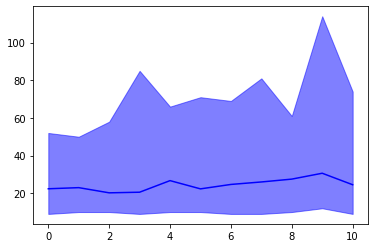

In [6]:
avg_returns = []
min_returns = []
max_returns = []

for i in range(epochs):
    batch_loss, batch_returns, batch_lengths = train_one_epoch()
    avg_returns.append(np.mean(batch_returns))
    min_returns.append(min(batch_returns))
    max_returns.append(max(batch_returns))
    print(f'epoch: {i} \t loss: {batch_loss:0.3f} \t '
          f'returns: {np.mean(batch_returns): 0.3f} [{np.std(batch_returns): 0.3f}] \t'
          f'lengths: {np.mean(batch_lengths): 0.3f} [{np.std(batch_lengths): 0.3f}]')
    if i%100 == 10:
        plt.fill_between(range(len(avg_returns)), min_returns, max_returns, color='blue', alpha=0.5)
        plt.plot(avg_returns, color='b')
        plt.show()



Write results

In [7]:
results = np.asarray([avg_returns, min_returns, max_returns])
np.save(weight_type + '.npy', results)

Load and draw results

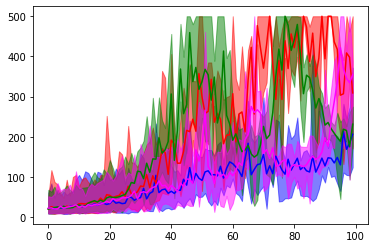

In [9]:
results = np.load('vanilla_pg.npy', 'r')
plt.fill_between(range(len(results[0])), results[1], results[2], color='blue', alpha=0.5)
plt.plot(results[0], color='b')

results = np.load('reward_to_go.npy', 'r')
plt.fill_between(range(len(results[0])), results[1], results[2], color='red', alpha=0.5)
plt.plot(results[0], color='r')

results = np.load('reward_to_go_with_value_baseline_old.npy', 'r')
plt.fill_between(range(len(results[0])), results[1], results[2], color='green', alpha=0.5)
plt.plot(results[0], color='g')

results = np.load('generalized_advantage_estimate.npy', 'r')
plt.fill_between(range(len(results[0])), results[1], results[2], color='magenta', alpha=0.5)
plt.plot(results[0], color='magenta')

plt.show()